# DCGAN to generate images using CelebA dataset

## Import libraries

In [1]:
import tensorflow as ts 
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np 
import matplotlib.pyplot as plt 
import os 
import zipfile
import gdown 

2024-08-05 23:45:44.180217: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-05 23:45:44.189115: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-05 23:45:44.199906: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-05 23:45:44.202936: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-05 23:45:44.210985: I tensorflow/core/platform/cpu_feature_guar

## Prepare Data

In [ ]:
!pip install kaggle

# Set user and dataset information
USER = 'jessicali9530'
DATASET = 'celeba-dataset'

# Define the dataset path
data_path = 'celeba_gan'  # Ensure this matches the intended path
os.makedirs(data_path, exist_ok=True)

# Download the dataset
!kaggle datasets download -d {USER}/{DATASET} -p {data_path}

# Check if the zip file exists
dataset_zip_path = os.path.join(data_path, f'{DATASET}.zip')
if os.path.exists(dataset_zip_path):
    # Unzip the dataset
    with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
        zip_ref.extractall(data_path)
    # Remove the zip file
    os.remove(dataset_zip_path)
    print('🚀 Done!')
else:
    print(f"Error: File '{dataset_zip_path}' not found. Please check if the dataset was downloaded correctly.")


Found 202599 files.


I0000 00:00:1722915952.966012  112112 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722915952.987964  112112 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722915952.988211  112112 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722915952.989812  112112 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722915952.989839  112112 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

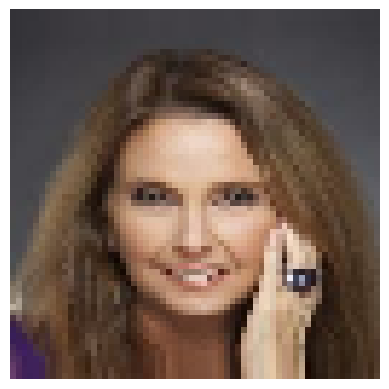

In [2]:
# create an image dataset
dataset= keras.preprocessing.image_dataset_from_directory ('celeba_gan', # path to images
                                                           label_mode=None, # no label
                                                           image_size=(64,64), # image size
                                                           batch_size=32)
# normalizing the image
dataset = dataset.map(lambda x: x/255.0)
# show a sample
for sample in dataset:
    plt.axis("off") # turn off the axis label
    plt.imshow((sample.numpy() * 255).astype("int32") [0])
    break

# Deep Convolutional GAN model

In [3]:
from tensorflow.keras import layers, Model
from tensorflow import Tensor

# Hyper parameters
input_shape = (64, 64, 3)
initial_feature_map = 64
num_block = 4
def conv_block (img: Tensor, filter: int , apply_batch : bool = True):
    x=layers.Conv2D(filters=filter, kernel_size=3, strides=2, padding='same')(img)
    if apply_batch:
        x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)  # Adjusted alpha to match common practice
    x = layers.Dropout(0.25)(x)  # shape: (batch, 64, H/2, W/2)
    return x
# Discriminator model
def Discriminator(input_shape: tuple= (64, 64, 3), initial_feature_map : int = 64, num_block : int = 4):
    ds_input = layers.Input(shape=input_shape)
    for idx  in range(num_block):
        if idx==0:
            x = conv_block (ds_input, initial_feature_map * (2**idx), apply_batch= False)
        else:
            x = conv_block (x, initial_feature_map * (2**idx), apply_batch= True)
    
    # Global Max Pooling
    x = layers.GlobalMaxPooling2D()(x)  # shape: (batch, 512)
    latent_dim =x.shape[-1]
    # Dense Layer
    dense_output = layers.Dense(1, activation='sigmoid')(x)
    
    # Create and return the model
    ds_model = Model(inputs=ds_input, outputs=dense_output)
    return ds_model, latent_dim

# Example usage
discriminator, latent_dim = Discriminator(input_shape = input_shape, initial_feature_map = initial_feature_map, num_block = num_block)
discriminator.summary()

/home/saeid23/anaconda3/envs/gan/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 512)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,555,073 (5.93 MB)

 Trainable params: 1,553,281 (5.93 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [4]:
# Generator model
def upconv_block(x : Tensor, filters: int):
    """Defines an upsampling convolutional block with optional batch normalization."""
    x = layers.Conv2DTranspose(filters=filters, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.ReLU()(x)
    return x

def Generator(latent_dim: int,
               output_shape: tuple = (64, 64, 3), 
               initial_feature_map: int = 64, 
               num_block: int = 4):
    
    gen_input = layers.Input(shape=(latent_dim,))
    # reshape latent vector into small image
    x = layers.Dense(output_shape[0]// (2** num_block) * output_shape[1]// (2** num_block) * latent_dim)(gen_input)
    x=layers.Reshape((output_shape[0]// (2** num_block),
                      output_shape[1]// (2** num_block), 
                      latent_dim))(x)
    # Upsample through several blocks
    for idx in range(num_block):
        x = upconv_block (x , latent_dim// (2** (idx +1)) )    
    # Output layer to generate the final image
    x = layers.Conv2D(filters=output_shape[-1], kernel_size=3, strides=1, padding='same', activation='sigmoid')(x)
    gen_model = Model(inputs= gen_input, outputs = x)
    return gen_model
generator = Generator(latent_dim, input_shape, initial_feature_map, num_block)
generator.summary()       

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8192)           │     4,202,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 256)      │     1,179,904 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,772,483 (22.02 MB)

 Trainable params: 5,771,523 (22.02 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# GAN model
import tensorflow as tf
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super (DCGAN, self).__init__()
        self.discriminator= discriminator
        self.generator = generator
        self.latent_dim = latent_dim
    def compile(self, ds_optimizer, gen_optimizer, loss_fn):
        super (DCGAN, self).compile()
        self.ds_optimizer = ds_optimizer
        self.gen_optimizer = gen_optimizer
        self.loss_fn = loss_fn
        self.ds_loss_metric = keras.metrics.Mean(name = 'ds_loss')
        self.gen_loss_metric = keras.metrics.Mean(name = 'gen_loss')
    @property
    def metrics(self):
        return [self.ds_loss_metric, self.gen_loss_metric]
    
    def train_step(self, real_images):
        batch_size = real_images.shape[0]
        # sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        # Generate a fake image using the random selected points from the latent space
        generated_images = self.generator (self.latent_dim, training=True)
        # concatenate them with the real images
        real_fake_images = tf.concat([generated_images , real_images], axis = 0)
        # labels -> fake images: 1, real images: 0
        labels = tf.concat([tf.ones(batch_size,1), tf.zeros(batch_size,1)], axis = 0)
        # Add random noise to labels to increase the models stability
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        
        # Train the discriminator
        with tf.GradientTape() as ds_tape:
            predictions = self.discriminator(real_fake_images)
            ds_loss = self.loss_fn(labels, predictions)
        grads_of_discriminator= ds_tape.gradient(ds_loss, self.discriminator.trainable_weights)
        self.ds_optimizer.apply_gradients(zip(grads_of_discriminator, self.discriminator.trainable_weights))
        self.ds_loss_metric.update_state(ds_loss)
        # Train the Generator
        misleading_labels = tf.zeros((batch_size, 1))
        with tf.GradientTape() as gen_tape:
            fake_predictions = self.discriminator(generated_images)
            gen_loss = self.loss_fn(misleading_labels, fake_predictions)
        grads_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_weights)
        self.gen_optimizer.apply_gradients(zip (grads_of_generator,  self.generator.trainable_weights))
        self.gen_loss_metric.update_state(gen_loss)
        return {
            "ds_loss" : self.ds_loss_metric.result (),
            "gen_loss" : self.gen_loss_metric.result(),
        }